# Importing Modules and Downloading Dataset

In [1]:
# Uncomment the below lines if they arent installed
!pip install catboost
!pip install openfe
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/ # Add your own file path for kaggle.json file

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 97% 64.0M/66.0M [00:03<00:00, 24.3MB/s]
100% 66.0M/66.0M [00:03<00:00, 17.7MB/s]


In [7]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import VotingClassifier

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

In [9]:
from openfe import OpenFE, transform

In [10]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error

In [11]:
from sklearn.metrics import f1_score

# Data Preprocessing and EDA

In [12]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The V features seem to be transformed PFA features to protect user information.

In [13]:
df.shape

(284807, 31)

In [14]:
df["Class"].unique() # We can see we have two classes

array([0, 1])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [16]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

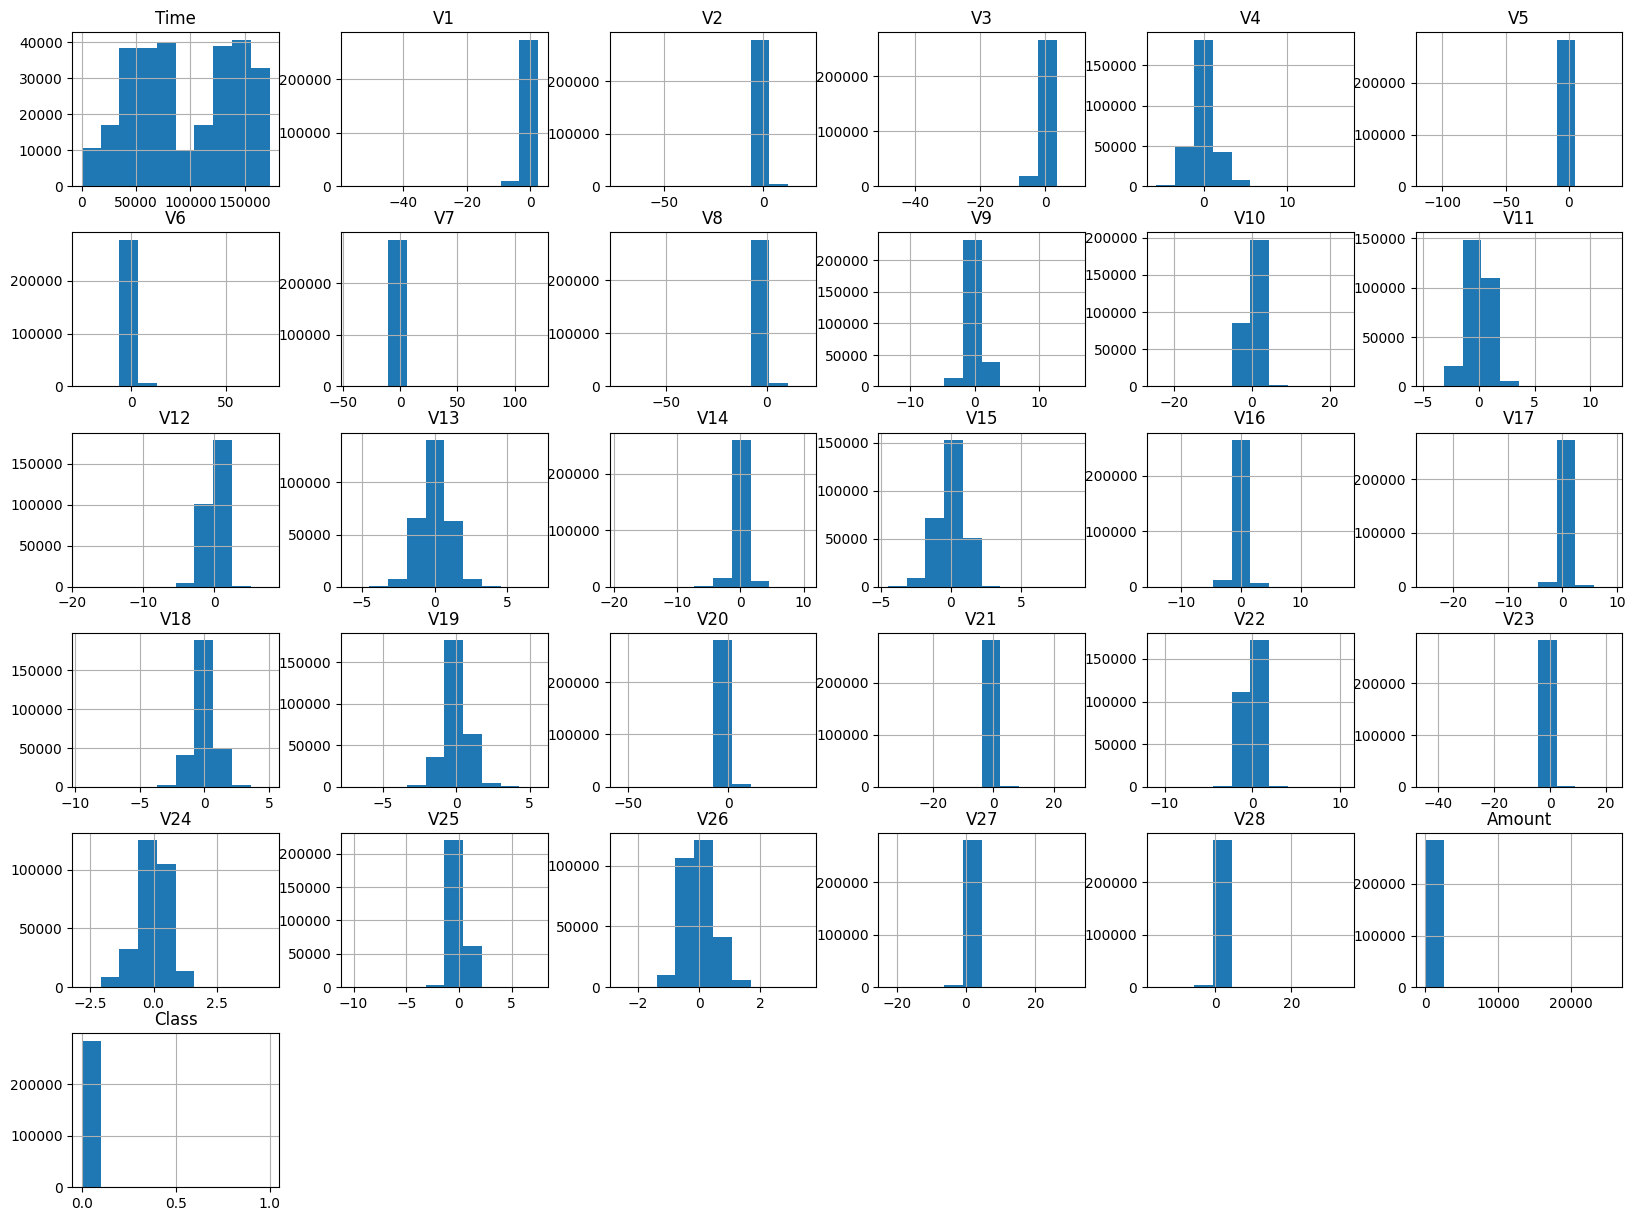

In [17]:
df.hist(figsize=(20,15));

This doesnt tell us much directly other than the fact that the Target class is very heavily unbalanced

Thus we make the target histogram below and try to see just how unbalanced it is.

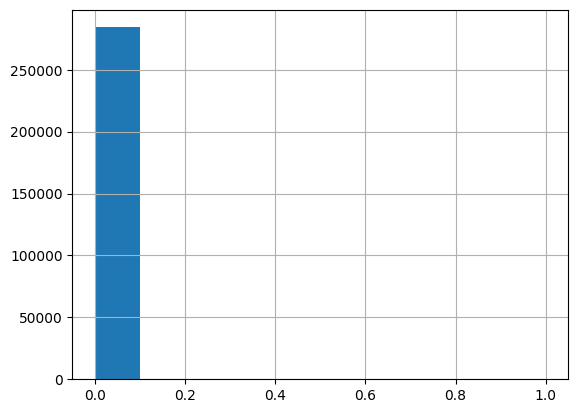

In [18]:
df["Class"].hist();

In [19]:
df.describe() # This way we get all the important statistical information about all our features and classes.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<Axes: >

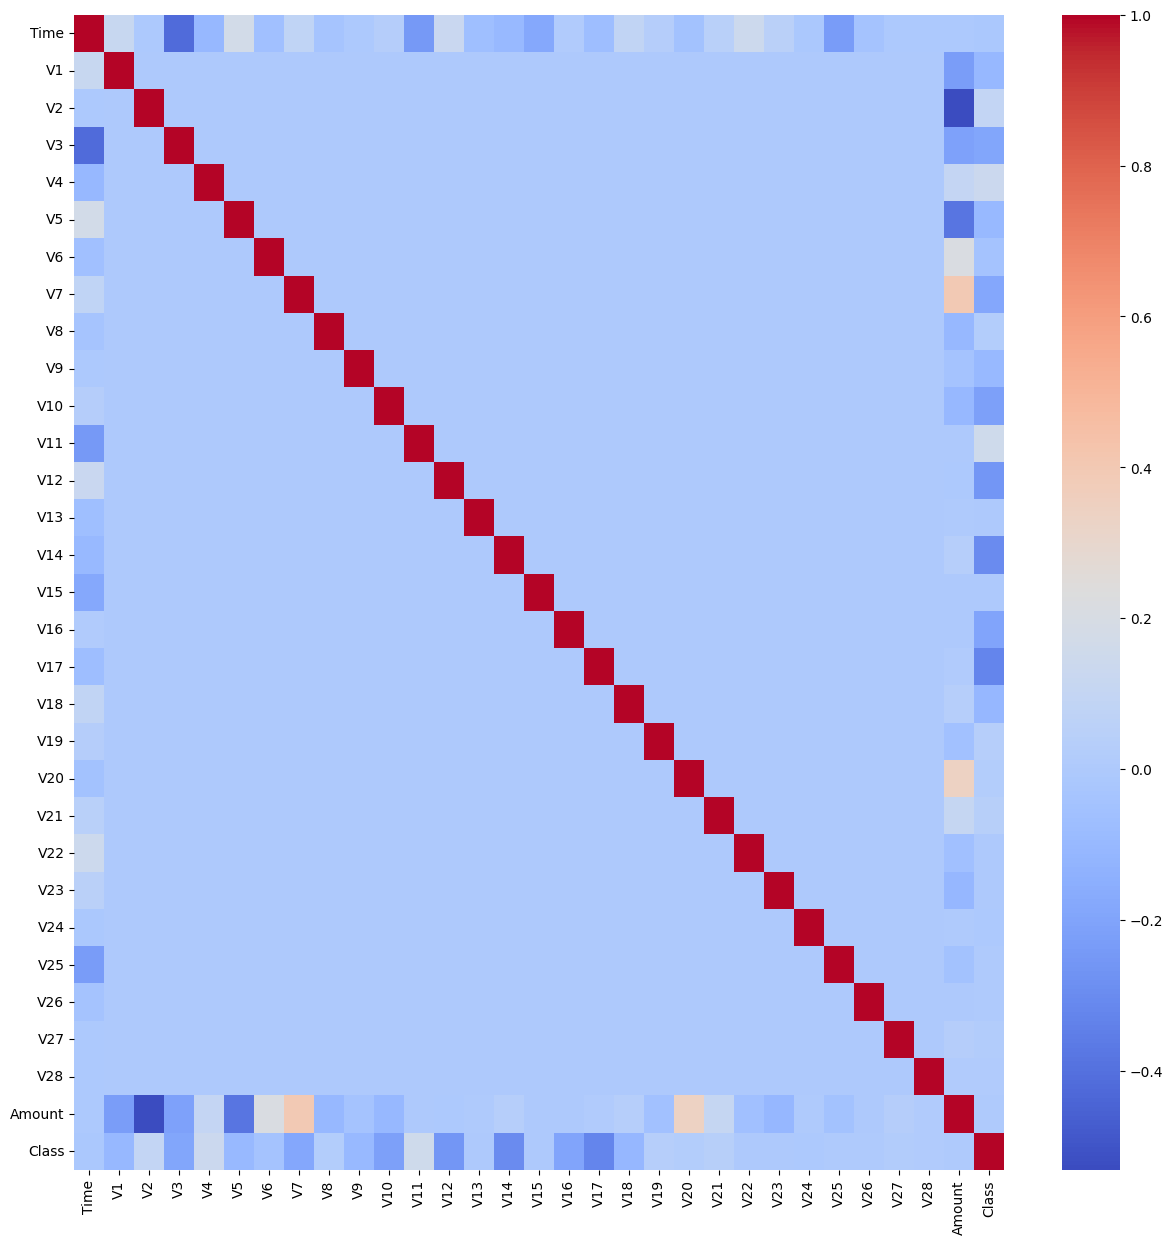

In [20]:
# Lets Make a heat map to visualise the correlations of already existing Features with each other
plt.figure(figsize = (15, 15))
sns.heatmap(data = df.corr(), cmap = "coolwarm")


Due to the unbalance of the dataset the correlation to target class is very less lets try to either make new features / balance the dataset

In [21]:
df.drop(["Time"]  ,axis = 1 ,  inplace = True)

In [22]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
df_exp = df.copy() # Just in Case i decide to experment on the df later on

# Splitting the dataset

In [24]:
X_train , X_val , y_train , y_val = train_test_split(df.drop("Class" , axis = 1) , df["Class"] , test_size = 0.2 , random_state = 42)

In [25]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(227845, 29)
(56962, 29)
(227845,)
(56962,)


# Oversampling to Balance The Dataset

In [26]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled_val, y_resampled_val = SMOTE().fit_resample(X_val, y_val)

<Axes: >

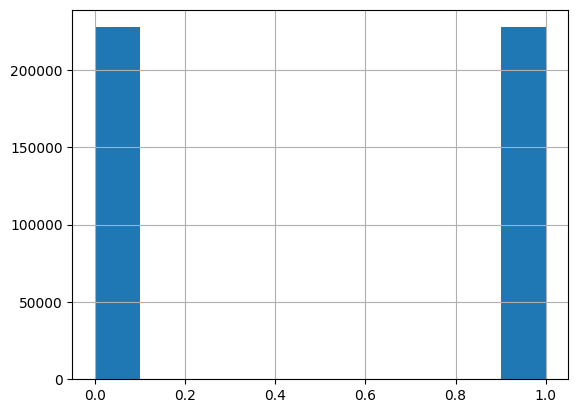

In [27]:
y_resampled.hist()

### Data is balanced again

### Starting with Model training  on various different Models


##### Random Forest


In [28]:
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_resampled, y_resampled)
rf_pred = rf_model.predict(X_resampled_val)
ac = accuracy_score(y_resampled_val, rf_pred)
auc = roc_auc_score(y_resampled_val, rf_pred)
print(ac)
print(auc)

0.9507860861001688
0.9507860861001688


In [29]:
more_pred_orignal = rf_model.predict(X_val)
more_ac = accuracy_score(y_val, more_pred_orignal)
more_auc = roc_auc_score(y_val, more_pred_orignal)
print(more_ac)
print(more_auc)

0.9995084442259752
0.9233550799329299


After oversampling the data the results on orignal dataset are still good althought it give the feel of overfitting

## Feature Importance

I Looking into sklearns feature_importances_ attribute to see the rate at which particular columns influenced the models predictions.

This gives us a picture into the models decision making process.

In [30]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [31]:
fi = rf_feat_importance(rf_model, X_resampled)
#fi[:10]
fi

,cols,imp
13,V14,0.157322
11,V12,0.119692
9,V10,0.117126
3,V4,0.115915
10,V11,0.097952
16,V17,0.083053
15,V16,0.047307
2,V3,0.041831
6,V7,0.029926
1,V2,0.024170


This is pretty much in accordance with our heatmap with the initial features influencing the decision more than latter ones

Thus we end up with a Random Forest Model with Accuracy ~95%

# Catboost Model

In [32]:
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10,task_type="GPU",devices='0')
cat_model = cat_model.fit(X_resampled, y_resampled, verbose=False)

#test set preds
cat_preds = cat_model.predict(X_resampled_val)

cat_preds_final = cat_preds


In [33]:
print(accuracy_score(y_resampled_val,cat_preds_final))
print(roc_auc_score(y_resampled_val,cat_preds_final))
print(f1_score(y_resampled_val,cat_preds_final))

0.9613639561057963
0.9613639561057963
0.9598207754206292


The Accuracy of Catboost is Around ~96%

# Trying XgBoost

In [34]:
from xgboost import XGBClassifier

In [35]:
gpu_params = {"tree_method": "gpu_hist", "predictor": "gpu_predictor"}

In [36]:
rf_model = XGBClassifier(n_estimators=100, min_child_weight=3, use_label_encoder=False, **gpu_params)
rf_model.fit(X_resampled, y_resampled)

rf_pred = rf_model.predict(X_resampled_val)
ac = accuracy_score(y_resampled_val, rf_pred)
auc = roc_auc_score(y_resampled_val, rf_pred)

print(ac)
print(auc)

0.9650130135059088
0.9650130135059087


The accuracy is almost 96.5% which is a great improvement from both Catboost and Randomforest

# LightGBM

In [37]:
# lgb_train = lgb.Dataset(X_resampled, label=y_resampled)
# lgb_eval = lgb.Dataset(X_resampled_val, label=y_resampled_val, reference=lgb_train)  # For evaluation

# Specify GPU device parameters (check LGBM docs for details)
gpu_params = {"device": "cpu"}

# Create and fit LGBMClassifier model with GPU parameters
rf_model_ldgb = lgb.LGBMClassifier(n_estimators=100, min_child_weight=3, **gpu_params)
rf_model_ldgb.fit(X_resampled , y_resampled)  # Early stopping can be added here

# LGBM predictions are done during training, access them from model
rf_pred = rf_model_ldgb.predict(X_resampled_val)

# Calculate accuracy and AUC using scikit-learn metrics
ac = accuracy_score(y_resampled_val, rf_pred)
auc = roc_auc_score(y_resampled_val, rf_pred)

print(ac)
print(auc)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.9692511958356781
0.9692511958356781


A whopping 97% which is the best accuracy we have gottten till now

Thus after going through three models and seeing their decisions and interpretability we can say LightGBM is the best we have gotten so far

# We Try Retraining the model on dataframes that are PCA of the given data frame for easier API creation


In [38]:
from sklearn.decomposition import PCA

# Assuming X_resampled, y_resampled, X_resampled_val, y_resampled_val are already defined

# PCA for training set
pca = PCA(n_components=2)
X_resampled_pca = pca.fit_transform(X_resampled)
X_resampled_pca_df = pd.DataFrame(X_resampled_pca)

# PCA for validation set
X_resampled_val_pca = pca.transform(X_resampled_val)
X_resampled_val_pca_df = pd.DataFrame(X_resampled_val_pca)

# Now you can train your LGBM model using X_resampled_pca_df and y_resampled,
# and validate it using X_resampled_val_pca_df and y_resampled_val

In [39]:
rf_model_lgb = lgb.LGBMClassifier(n_estimators=100, min_child_weight=3, **gpu_params)
rf_model_lgb.fit(X_resampled_pca_df, y_resampled)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(device='cpu', min_child_weight=3)

In [40]:
# prompt: write the prediction and evaluation code using different metrics for the rf_model_lgb on dataframe X_resampled_val_pca_df

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Predict using the LGBM model
y_pred = rf_model_lgb.predict(X_resampled_val_pca_df)

# Calculate accuracy, AUC, and F1 score
accuracy = accuracy_score(y_resampled_val, y_pred)
auc = roc_auc_score(y_resampled_val, y_pred)
f1 = f1_score(y_resampled_val, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("AUC:", auc)
print("F1 Score:", f1)


Accuracy: 0.937438449634215
AUC: 0.937438449634215
F1 Score: 0.934799541809851


As we can see the model starts to bleed when we apply pca like this for practical use

# Saving and exporting model for api development


In [41]:
import pickle

# Save the model to a file
with open('/content/drive/MyDrive/Kaggle/creditcard_fraud_lgb(1).pkl', 'wb') as f:
  pickle.dump(rf_model_lgb, f)

# Load the model from the file
with open('/content/drive/MyDrive/Kaggle/creditcard_fraud_lgb(1).pkl', 'rb') as f:
  model = pickle.load(f)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [52]:
# app = FastAPI()
# @app.get('/')
# def main():
#     return { 'message'  : 'This is a test endpoint'}

In [54]:
# @app.get('/predict')
# def predict(input_data:dict):
#     input_data = pd.DataFrame(input_data)
#     amount = input_data['Amount']
#     input_data_num = input_data.drop(['Name', 'Amount'], axis=1)
#     pca = PCA(n_components=28)
#     input_data_pca = pca.fit_transform(input_data_num)
#     input_data_final = np.column_stack((input_data_pca, amount))
#     prediction = rf_model_ldgb.predict(input_data_final)
#     if prediction[0] == 1:
#       result = "Fraud"
#     else:
#       result = "Not Fraud"
#     return { 'prediction' : result}